# FUSION NET : CNN + Transfer Learning + XGBoost Ensemble

##### DATA : FOOD 101

TASKS:
Classification - predict the food (pizza or steak)
Base Model(level-0) : CNN, XGBoost(on CNN features)
Meta Learner(level-1): TensorFlow Dense model

The dataset follows a typical image classification folder structure, divided into separate subsets.

It contains two classes:

pizza/

steak/

Each subset (train, test, val) has its own folder containing these two categories.

### DATA LOADING

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-11-19 17:12:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  25.8MB/s    in 5.0s    

2025-11-19 17:12:05 (21.0 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



Inspecting Data

In [2]:
!ls pizza_steak
!ls pizza_steak/train/
!ls pizza_steak/train/steak/ | head -5

test  train
pizza  steak
1000205.jpg
100135.jpg
101312.jpg
1021458.jpg
1032846.jpg


In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"Directories: {len(dirnames)} || {len(filenames)} images in '{dirpath}'")

Directories: 2 || 0 images in 'pizza_steak'
Directories: 2 || 0 images in 'pizza_steak/train'
Directories: 0 || 750 images in 'pizza_steak/train/pizza'
Directories: 0 || 750 images in 'pizza_steak/train/steak'
Directories: 2 || 0 images in 'pizza_steak/test'
Directories: 0 || 250 images in 'pizza_steak/test/pizza'
Directories: 0 || 250 images in 'pizza_steak/test/steak'


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mp
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mp.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape is {img.shape}") # returns (width, height, colour channels)
  return img

Image shape is (384, 512, 3)


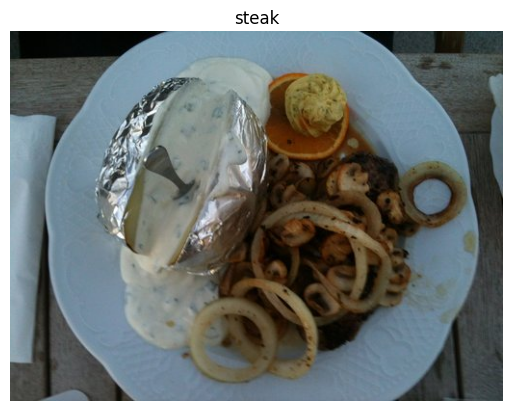

In [5]:
img = view_random_image(target_dir="pizza_steak/train/", target_class= "steak")

The image shape is in form of Width, Height, Color Channels.
Color Channels value is always 3 for RGB.

array([[[28, 37, 34],
        [23, 32, 29],
        [20, 29, 26],
        ...,
        [43, 61, 63],
        [45, 63, 65],
        [44, 62, 64]],

       [[22, 31, 28],
        [18, 27, 24],
        [17, 26, 23],
        ...,
        [45, 63, 65],
        [50, 68, 70],
        [51, 69, 71]],

       [[18, 27, 24],
        [15, 24, 21],
        [14, 23, 20],
        ...,
        [50, 68, 70],
        [49, 67, 69],
        [45, 63, 65]],

       ...,

       [[76, 77, 72],
        [76, 77, 72],
        [76, 77, 72],
        ...,
        [54, 64, 66],
        [57, 67, 69],
        [60, 70, 72]],

       [[73, 74, 69],
        [75, 76, 71],
        [76, 77, 72],
        ...,
        [51, 61, 63],
        [54, 64, 66],
        [57, 67, 69]],

       [[70, 71, 66],
        [73, 74, 69],
        [75, 76, 71],
        ...,
        [54, 64, 66],
        [57, 67, 69],
        [60, 70, 72]]], dtype=uint8)
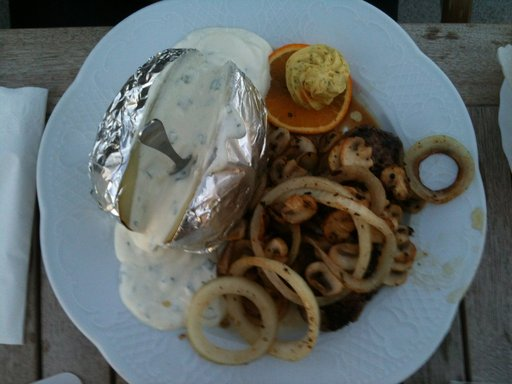

In [6]:
img

Normalizing the image. Getting pixel values between 0 and 1

In [7]:
#img/255
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

### Checking with Baseline models


#### Preprocessing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
# converting to batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode= 'binary')

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [10]:
class_names = list(train_data.class_indices.keys())
print(class_names)

['pizza', 'steak']


In [11]:
images, labels = next(iter(train_data))
len(images), len(labels)

(32, 32)

In [12]:
images[:1], images[0].shape

(array([[[[0.7372549 , 0.7490196 , 0.72156864],
          [0.75294125, 0.7607844 , 0.7411765 ],
          [0.7490196 , 0.7568628 , 0.74509805],
          ...,
          [0.10196079, 0.09411766, 0.1137255 ],
          [0.11764707, 0.10980393, 0.12156864],
          [0.08235294, 0.08235294, 0.08235294]],
 
         [[0.73333335, 0.74509805, 0.7176471 ],
          [0.75294125, 0.7607844 , 0.7411765 ],
          [0.75294125, 0.7607844 , 0.7490196 ],
          ...,
          [0.1254902 , 0.11764707, 0.12941177],
          [0.09019608, 0.08235294, 0.09411766],
          [0.10980393, 0.10196079, 0.10588236]],
 
         [[0.7254902 , 0.7372549 , 0.70980394],
          [0.7568628 , 0.76470596, 0.74509805],
          [0.7725491 , 0.7725491 , 0.76470596],
          ...,
          [0.07843138, 0.07058824, 0.07450981],
          [0.10196079, 0.09411766, 0.09803922],
          [0.14901961, 0.14117648, 0.14509805]],
 
         ...,
 
         [[0.7725491 , 0.7568628 , 0.74509805],
          [0.76862

In [13]:
labels

array([1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

baseline_model = Sequential([
    Conv2D(filters=10,  # NUMBER OF FEATURE EXTRACTORS
           kernel_size = 3, # size of filter
           strides = 1,  # filter move by 1 px
           padding = "valid", # same adds 0 outside of image while valid cut off excess px where filter doesnot fit
           activation = "relu",
           input_shape = (224,224,3)
           ),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    Flatten(),
    Dense(1, activation = "sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer = Adam(),
                       metrics = ['accuracy'])

In [16]:
baseline_model_history= baseline_model.fit(train_data,
                                           epochs = 5,
                                           steps_per_epoch = len(train_data),
                                           validation_data = test_data,
                                           validation_steps = len(test_data)
                                           )

train_loss, train_acc = baseline_model.evaluate(train_data)
test_loss, test_acc = baseline_model.evaluate(test_data)


print("\n")
print("______________Baseline Model_____________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.5934 - loss: 1.2601 - val_accuracy: 0.8100 - val_loss: 0.4055
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.8226 - loss: 0.4321 - val_accuracy: 0.8500 - val_loss: 0.3636
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 613ms/step - accuracy: 0.9177 - loss: 0.2547 - val_accuracy: 0.8400 - val_loss: 0.3863
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 604ms/step - accuracy: 0.9633 - loss: 0.1322 - val_accuracy: 0.7700 - val_loss: 0.5154
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.9937 - loss: 0.0503 - val_accuracy: 0.8300 - val_loss: 0.4573
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0109
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8503 - loss: 0.4075


______________Baseline Model_____________


Train Loss: 1.059887744486332 || Train Accuracy: 100.0
Test Loss: 45.72848379611969 || Test Accuracy: 82.99999833106995


<Axes: >

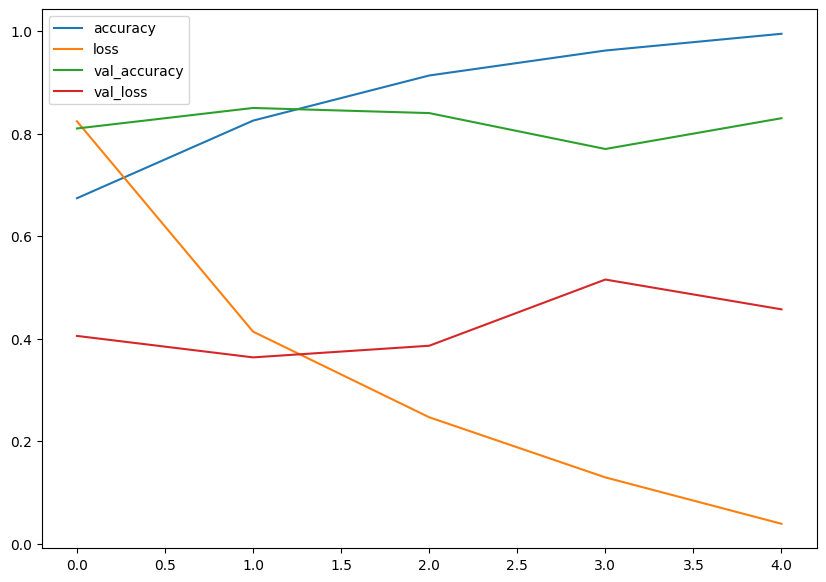

In [17]:
import pandas as pd
pd.DataFrame(baseline_model_history.history).plot(figsize=(10, 7))

The model memorized the training images

In [18]:
def plot_loss_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss,label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

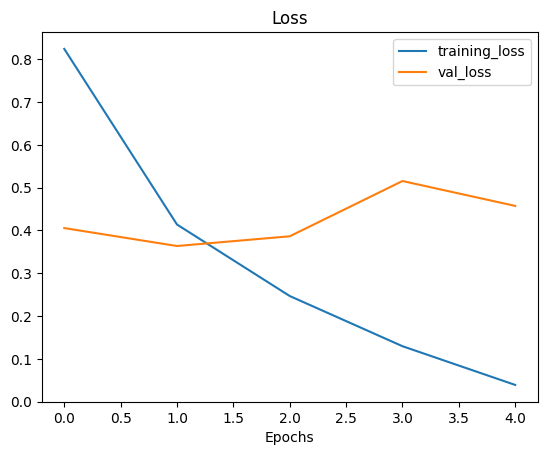

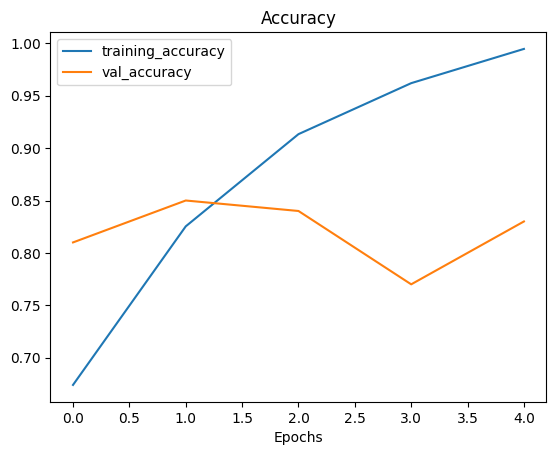

In [19]:
plot_loss_curve(baseline_model_history)

In [20]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 218, 218, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 475240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       475,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,432,025 (5.46 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,684 (3.64 MB)

 Now, we know we have to adjust model parameters to reduce overfitting.


In [21]:
model1 = Sequential([
    Conv2D(10, 3, activation = "relu", input_shape = (224,224,3)),
    MaxPool2D(pool_size = 2), # reduce number of feature by half
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = Adam(),
               metrics = ['accuracy']
               )

In [23]:
model1_history = model1.fit(train_data,
                           epochs = 5,
                           steps_per_epoch = len(train_data),
                           validation_data = test_data,
                           validation_steps = len(test_data))

train_loss, train_acc = model1.evaluate(train_data)
test_loss, test_acc = model1.evaluate(test_data)

print("\n")
print("______________Model1 : Using MaxPool to reduce feature______________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.5524 - loss: 0.6747 - val_accuracy: 0.6720 - val_loss: 0.5788
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.7330 - loss: 0.5199 - val_accuracy: 0.8020 - val_loss: 0.4448
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.7649 - loss: 0.4653 - val_accuracy: 0.8440 - val_loss: 0.3892
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.7916 - loss: 0.4457 - val_accuracy: 0.8200 - val_loss: 0.4097
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.8205 - loss: 0.4176 - val_accuracy: 0.8580 - val_loss: 0.3481
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8519 - loss: 0.3508
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8117 - loss: 0.3881


______________Model1 : Using MaxPool to reduce feature______________


Train Loss: 34.56048667430878 || Train Accuracy: 85.6000006198883
Test Loss: 34.80520844459534 || Test Accuracy: 85.79999804496765


In [24]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

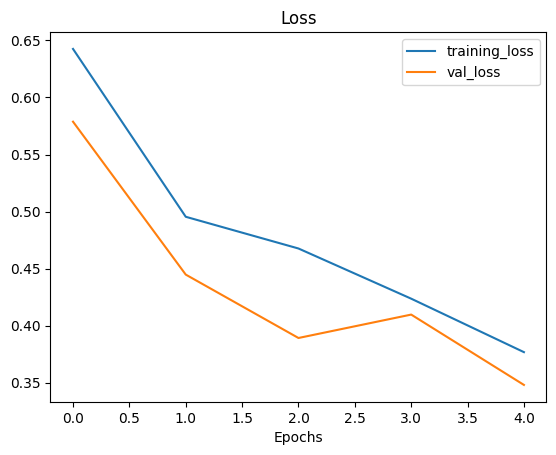

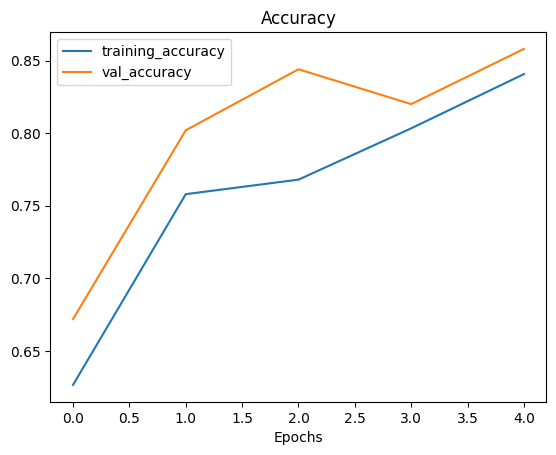

In [25]:
plot_loss_curve(model1_history)

Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

In [26]:
train_datagen_augmented = ImageDataGenerator(rescale=1./255.,
                                             rotation_range = 20,
                                             shear_range = 0.2,
                                             zoom_range=0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [27]:
print("Augmented Training Images:")

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                    target_size = (224, 224),
                                                                    batch_size = 32,
                                                                    class_mode = 'binary',
                                                                    shuffle = False)

print("Non Augmented Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size = 32,
                                               class_mode = 'binary',
                                               shuffle = False)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 32)

Augmented Training Images:
Found 1500 images belonging to 2 classes.
Non Augmented Training Images:
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [28]:
images, labels = next(iter(train_data))
images_augmented, labels_augmented = next(iter(train_data_augmented))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

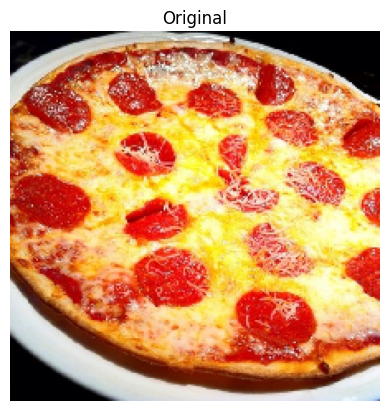

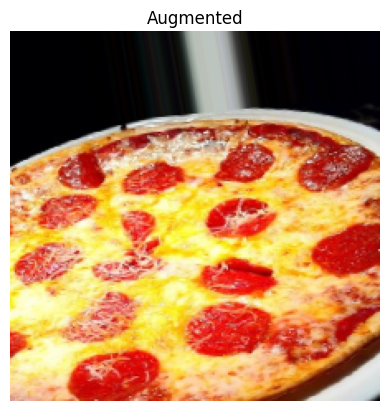

In [29]:
random_number = random.randint(0, 31)
plt.imshow(images[random_number])

plt.title(f"Original")
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number])
plt.title(f"Augmented")
plt.axis(False)

In [30]:
model2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape = (224,224,3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

model2_history = model2.fit(train_data_augmented,
                            epochs = 5,
                            steps_per_epoch = len(train_data_augmented),
                            validation_data = test_data,
                            validation_steps = len(test_data)
                            )

train_loss, train_acc = model2.evaluate(train_data)
test_loss, test_acc = model2.evaluate(test_data)

print("\n")
print("____________Model2 : Augmenting Data (shuffle=false)____________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.3399 - loss: 0.7706 - val_accuracy: 0.6380 - val_loss: 0.6822
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4790 - loss: 0.6942 - val_accuracy: 0.5020 - val_loss: 0.6894
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.4614 - loss: 0.7055 - val_accuracy: 0.7680 - val_loss: 0.6388
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.6567 - loss: 0.6532 - val_accuracy: 0.5680 - val_loss: 0.6549
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.4559 - loss: 0.7257 - val_accuracy: 0.7580 - val_loss: 0.5768
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6962 - loss: 0.6278
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7306 - loss: 0.5935


____________Model2 : Augmenting Data (shuffle=false)____________


Train Loss: 58.77864360809326 || Train Accuracy: 72.60000109672546
Test Loss: 57.68110752105713 || Test Accuracy: 75.80000162124634


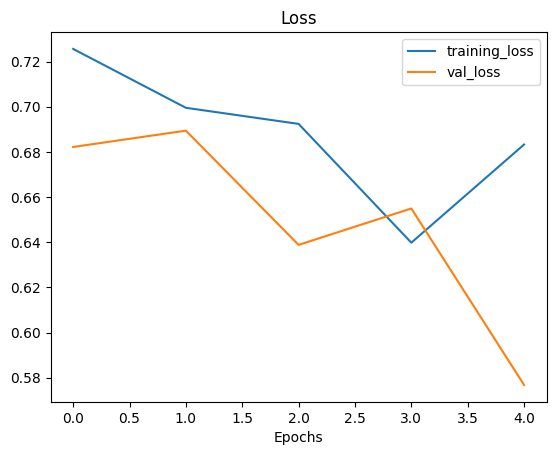

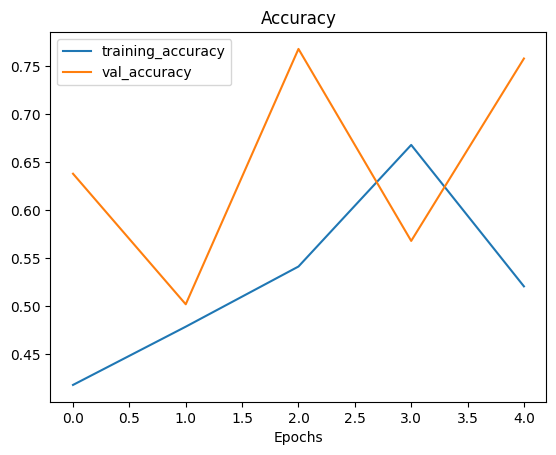

In [31]:
plot_loss_curve(model2_history)


Shuffle data

In [32]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                    target_size = (224, 224),
                                                                    batch_size = 32,
                                                                    class_mode = 'binary',
                                                                    shuffle = True)

Found 1500 images belonging to 2 classes.


In [33]:
model3 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape = (224,224,3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

model3_history = model3.fit(train_data_augmented_shuffled,
                            epochs = 5,
                            steps_per_epoch = len(train_data_augmented_shuffled),
                            validation_data = test_data,
                            validation_steps = len(test_data)
                            )

train_loss, train_acc = model3.evaluate(train_data)
test_loss, test_acc = model3.evaluate(test_data)

print("\n")
print("___________Model3 : Augmenting Data (shuffle=true)____________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.5225 - loss: 0.6886 - val_accuracy: 0.7180 - val_loss: 0.5817
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.7187 - loss: 0.5690 - val_accuracy: 0.8600 - val_loss: 0.3444
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.7439 - loss: 0.5048 - val_accuracy: 0.7720 - val_loss: 0.4846
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.8137 - loss: 0.4311 - val_accuracy: 0.8780 - val_loss: 0.3022
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step - accuracy: 0.7806 - loss: 0.4658 - val_accuracy: 0.8760 - val_loss: 0.3142
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8341 - loss: 0.4179
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8726 - loss: 0.3263


___________Model3 : Augmenting Data (shuffle=true)____________


Train Loss: 37.9984587430954 || Train Accuracy: 84.13333296775818
Test Loss: 31.421580910682678 || Test Accuracy: 87.59999871253967


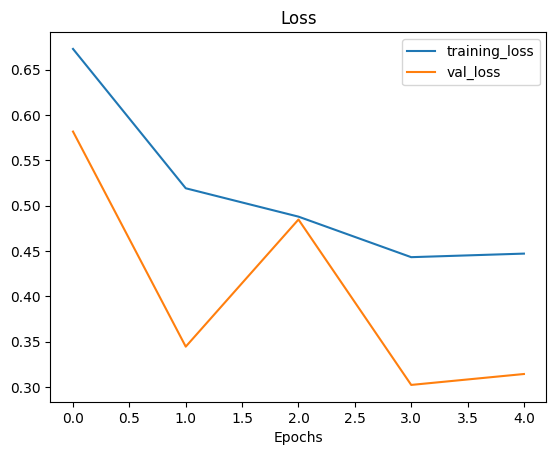

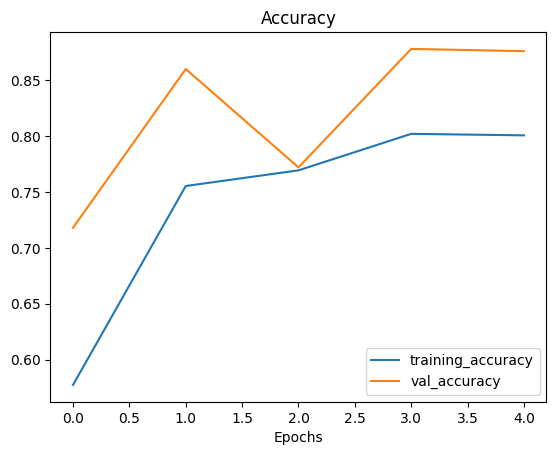

In [34]:
plot_loss_curve(model3_history)

Increase the number of filters in each convolutional layer (from 10 to 32, 64, or 128,
                                                            these numbers aren't set in stone either, they are usually found through trial and error).

In [35]:
model4 = Sequential([
  Conv2D(64, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(128, 3, activation='relu'),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history4 = model4.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

train_loss, train_acc = model4.evaluate(train_data)
test_loss, test_acc = model4.evaluate(test_data)

print("\n")
print("___________Model3 : Augmenting Data (shuffle=true) More Layer____________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")

NameError: name 'tf' is not defined

In [ ]:
model4.summary()

Adding Dropout Layer

In [37]:
from tensorflow.keras.layers import Dropout
import tensorflow as tf # Added this line

model5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history5 = model5.fit(train_data_augmented_shuffled,
                        epochs=20,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

train_loss, train_acc = model5.evaluate(train_data)
test_loss, test_acc = model5.evaluate(test_data)

print("\n")
print("___________Model3 : Augmenting Data (shuffle=true) More Layer____________")
print("\n")
print(f"Train Loss: {train_loss*100} || Train Accuracy: {train_acc*100}")
print(f"Test Loss: {test_loss*100} || Test Accuracy: {test_acc*100}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.5651 - loss: 0.8336 - val_accuracy: 0.8200 - val_loss: 0.4242
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7652 - loss: 0.5034 - val_accuracy: 0.7580 - val_loss: 0.4584
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.7186 - loss: 0.5398 - val_accuracy: 0.7400 - val_loss: 0.5326
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.7160 - loss: 0.5550 - val_accuracy: 0.8480 - val_loss: 0.3809
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.7640 - loss: 0.4953 - val_accuracy: 0.8560 - val_loss: 0.3494
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - accuracy: 0.7888 - loss: 0.4716 - val_accuracy: 0.8420 - val_loss: 0.3493
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.7865 - loss: 0.4665 - val_accuracy: 0.8480 - val_loss: 0.3598
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.7941 - loss: 0.4601 - val_accuracy: 0.8020 - v

### Prediction

--2025-11-19 18:44:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  11.9MB/s    in 0.2s    

2025-11-19 18:44:32 (11.9 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

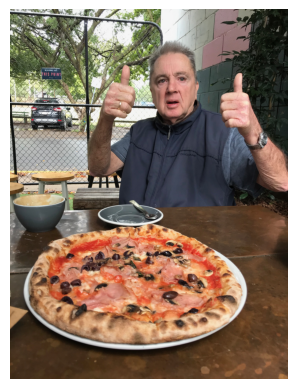

In [38]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
test_img = mp.imread("03-pizza-dad.jpeg")
plt.imshow(test_img)
plt.axis(False)

In [39]:
test_img.shape

(4032, 3024, 3)

In [40]:
def load_prepare_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255
  return img

In [41]:
test_image = load_prepare_image("03-pizza-dad.jpeg")
test_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.2887255 , 0.3009804 , 0.2632353 ],
        [0.44705883, 0.47843137, 0.39607844],
        [0.57598037, 0.5955882 , 0.5093137 ],
        ...,
        [0.05686275, 0.06862745, 0.04117647],
        [0.05588235, 0.0754902 , 0.04803922],
        [0.07745098, 0.08921569, 0.06176471]],

       [[0.9377451 , 0.9553922 , 0.9651961 ],
        [0.8838235 , 0.9102941 , 0.92107844],
        [0.9411765 , 0.9607843 , 0.9588235 ],
        ...,
        [0.04313726, 0.05490196, 0.02745098],
        [0.07843138, 0.09019608, 0.0627451 ],
        [0.08186275, 0.10147059, 0.07401961]],

       [[0.12745099, 0.13529412, 0.12352941],
        [0.175     , 0.17450981, 0.16617647],
        [0.12941177, 0.14901961, 0.13333334],
        ...,
        [0.03431373, 0.05196078, 0.0245098 ],
        [0.05833333, 0.07009804, 0.04264706],
        [0.05343137, 0.08088236, 0.0495098 ]],

       ...,

       [[0.24264705, 0.16029412, 0.07794118],
        [0.23

In [42]:
test_image.shape

TensorShape([224, 224, 3])

 The model was trained on data in the shape of (batch_size, 224, 224, 3).

Fix this by adding an extra to our custom image tensor using tf.expand_dims.

In [43]:
test_image = tf.expand_dims(test_image, axis = 0)
test_image.shape


TensorShape([1, 224, 224, 3])

In [44]:
pred = model5.predict(test_image)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


array([[0.09021387]], dtype=float32)

 The predictions come out in prediction probability form. In other words, this means how likely the image is to be one class or another.

In [45]:
class_names

['pizza', 'steak']

In [46]:
def pred_and_plot(model, filename, class_names):
  img = load_prepare_image(filename)
  pred = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[int(tf.round(pred)[0][0])]
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  return pred_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


'pizza'

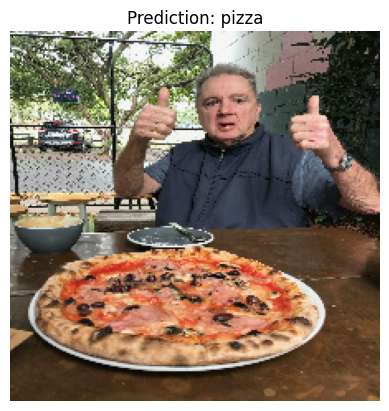

In [47]:
pred_and_plot(model5, "03-pizza-dad.jpeg", class_names)

--2025-11-19 18:44:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  10.4MB/s    in 0.2s    

2025-11-19 18:44:54 (10.4 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


'steak'

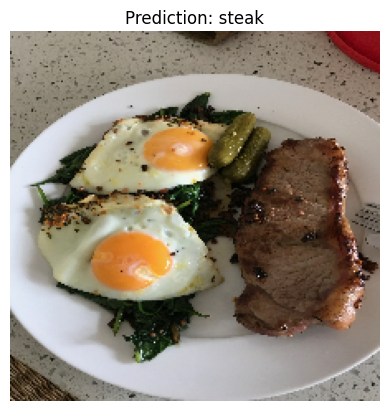

In [48]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
pred_and_plot(model5, "03-steak.jpeg", class_names)

### Transfer Learning - Mobilenet

In [49]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size = 32,
                                               class_mode = 'binary',
                                               shuffle = True)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 32,
                                             shuffle = False
                                             )

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [50]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])

In [51]:
# The 'data_augmentation' Sequential model is meant for tf.data.Dataset objects, not DirectoryIterator.
# The 'train_data' iterator already includes preprocessing via the ImageDataGenerator.
# train_aug = train_data.map(lambda x, y: (data_augmentation(x, training=True), y)) # This line caused the error.

In [52]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_mobilenet = tf.keras.Model(inputs, outputs)

model_mobilenet.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(train_data_augmented_shuffled,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_augmented_shuffled),
                                        validation_data=test_data,
                                        validation_steps=len(test_data))

train_loss_mobilenet, train_acc_mobilenet = model_mobilenet.evaluate(train_data)
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(test_data)

print("\n")
print("______________MobileNetV2 Transfer Learning Model______________")
print("\n")
print(f"Train Loss: {train_loss_mobilenet*100} || Train Accuracy: {train_acc_mobilenet*100}")
print(f"Test Loss: {test_loss_mobilenet*100} || Test Accuracy: {test_acc_mobilenet*100}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7040 - loss: 0.5442

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 534ms/step - accuracy: 0.7068 - loss: 0.5409 - val_accuracy: 0.9760 - val_loss: 0.1229
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9298 - loss: 0.2050 - val_accuracy: 0.9860 - val_loss: 0.0757
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.9408 - loss: 0.1530 - val_accuracy: 0.9920 - val_loss: 0.0607
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 496ms/step - accuracy: 0.9729 - loss: 0.1091 - val_accuracy: 0.9900 - val_loss: 0.0572
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.9626 - loss: 0.1184 - val_accuracy: 0.9900 - val_loss: 0.0538
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.9691 - loss: 0.0974
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.9849 - loss: 0.0781


______________MobileNetV2 Transfer Learning Model______________


Train Loss: 10.799780488014221 || Train Accuracy: 96.26666903495789
Test Loss: 5.380278080701828 || Test Accuracy: 99.00000095367432


#### PREDICTION

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


'pizza'

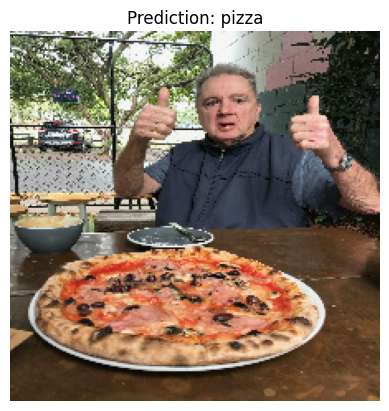

In [53]:
pred_and_plot(model_mobilenet, "03-pizza-dad.jpeg", class_names)

In [54]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

efficient_train_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess_input,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

efficient_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess_input)

efficient_train_data = efficient_train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

efficient_test_data = efficient_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


efficient_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

efficient_base.trainable = False


inputs = tf.keras.Input(shape=(224, 224, 3))
x = efficient_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

efficient_model = tf.keras.Model(inputs, outputs)

efficient_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

history_efficient = efficient_model.fit(
    efficient_train_data,
    epochs=5,
    steps_per_epoch=len(efficient_train_data),
    validation_data=efficient_test_data,
    validation_steps=len(efficient_test_data)
)

train_loss_eff, train_acc_eff = efficient_model.evaluate(efficient_train_data)
test_loss_eff, test_acc_eff = efficient_model.evaluate(efficient_test_data)

print("\n")
print("______________ EfficientNetB0 Transfer Learning Model ______________")
print("\n")
print(f"Train Accuracy: {train_acc_eff * 100:.2f}%")
print(f"Test  Accuracy: {test_acc_eff * 100:.2f}%")

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - accuracy: 0.8168 - loss: 0.4734 - val_accuracy: 0.9920 - val_loss: 0.1136
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 755ms/step - accuracy: 0.9603 - loss: 0.1675 - val_accuracy: 0.9960 - val_loss: 0.0608
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 765ms/step - accuracy: 0.9611 - loss: 0.1258 - val_accuracy: 0.9960 - val_loss: 0.0448
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 747ms/step - accuracy: 0.9710 - loss: 0.1029 - val_accuracy: 0.9960 - val_loss: 0.0368
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 735ms/step - accuracy: 0.9734 - loss: 0.0904 - val_accuracy: 0.9960 - val_loss: 0.0325
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 553ms/step - accuracy: 0.9785 - loss: 0.0721
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 536ms/step - accuracy: 0.9952 - loss: 0.0355


______________ EfficientNetB0 Transfer Learning Model ______________


Tr

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'pizza'

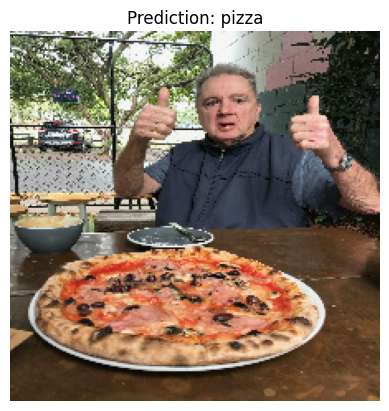

In [55]:
pred_and_plot(efficient_model, "03-pizza-dad.jpeg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


'pizza'

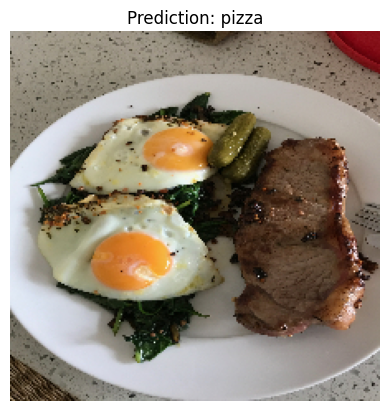

In [56]:
pred_and_plot(efficient_model, "03-steak.jpeg", class_names)

### Feature Extraction For XGBoost

In [57]:
efficient_feature_extractor = tf.keras.Model(
    inputs = efficient_model.input,
    outputs = efficient_model.layers[-2].output
)

In [58]:
import numpy as np

def extract_features(features_extractor, data):
  features = []
  labels = []

  for batch_imgs, batch_labels in data:
    batch_features = features_extractor.predict(batch_imgs)
    features.append(batch_features)
    labels.append(batch_labels)

    if len(features)* data.batch_size >= data.samples:
      break

  return np.concatenate(features), np.concatenate(labels)

In [59]:
X_train, y_train = extract_features(efficient_feature_extractor, efficient_train_data)
X_test, y_test = extract_features(efficient_feature_extractor, efficient_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [60]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1500, 1280)
(500, 1280)
(1500,)
(500,)


In [61]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_eff = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_eff.fit(X_train, y_train)

xgb_pred_test = xgb_eff.predict(X_test)
xgb_test_acc = accuracy_score(y_test, xgb_pred_test)

print(f"\nXGBoost Test Accuracy (EfficientNet features): {xgb_test_acc*100:.2f}%")



XGBoost Test Accuracy (EfficientNet features): 99.40%


### Full Stacking Pipeline

In [62]:
pred_cnn = model5.predict(test_data).reshape(-1, 1)
pred_mobile = model_mobilenet.predict(test_data).reshape(-1, 1)
pred_eff = efficient_model.predict(efficient_test_data).reshape(-1, 1)
pred_xgb = xgb_eff.predict_proba(X_test)[:,1].reshape(-1,1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 979ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 615ms/step


In [63]:
meta_X = np.concatenate([pred_cnn, pred_mobile, pred_eff, pred_xgb], axis = 1)
meta_y = y_test


In [64]:
meta_model = Sequential([
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

meta_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(),
                     metrics=['accuracy'])

meta_history = meta_model.fit(meta_X,
                              meta_y,
                              epochs=20,
                              batch_size = 32)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5989 - loss: 0.5974
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7907 - loss: 0.5671 
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.5173 
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8699 - loss: 0.4835 
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8992 - loss: 0.4463 
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9155 - loss: 0.4245 
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9244 - loss: 0.3566 
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9552 - loss: 0.3467 
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9601 - loss: 0.3213 
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9600 - loss: 0.3007 
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.2488 
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

In [65]:
meta_pred = (meta_model.predict(meta_X) > 0.5).astype(int)
stacked_acc = accuracy_score(meta_y, meta_pred)

print(f"\nFINAL STACKED MODEL ACCURACY: {stacked_acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

FINAL STACKED MODEL ACCURACY: 99.60%


### Prediction on image

In [87]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_pizza_dir = "pizza_steak/test/pizza"
test_steak_dir = "pizza_steak/test/steak"

all_test_images = (
    [os.path.join(test_pizza_dir, f) for f in os.listdir(test_pizza_dir)] +
    [os.path.join(test_steak_dir, f) for f in os.listdir(test_steak_dir)]
)

random_image_path = random.choice(all_test_images)
print("Random test image:", random_image_path)


Random test image: pizza_steak/test/pizza/573054.jpg


In [72]:
img_norm = img_arr / 255.0
img_norm_batch = np.expand_dims(img_norm, axis=0)
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

img_eff = eff_preprocess(img_arr.copy())
img_eff_batch = np.expand_dims(img_eff, axis=0)

In [74]:
mobile_feat = model_mobilenet.predict(img_norm_batch)
eff_feat = efficient_model.predict(img_eff_batch)
xgb_input = np.concatenate([mobile_feat, eff_feat], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [76]:
pred_cnn_single = model5.predict(img_norm_batch).reshape(-1,1)
pred_mobile_single = model_mobilenet.predict(img_norm_batch).reshape(-1,1)
pred_eff_single = efficient_model.predict(img_eff_batch).reshape(-1,1)

single_image_eff_features = efficient_feature_extractor.predict(img_eff_batch)
pred_xgb_single = xgb_eff.predict_proba(single_image_eff_features)[:, 1].reshape(-1,1)
meta_X_single = np.concatenate([pred_cnn_single, pred_mobile_single, pred_eff_single, pred_xgb_single], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
FINAL PREDICTION: STEAK 
Meta-model raw probability: 0.9915223


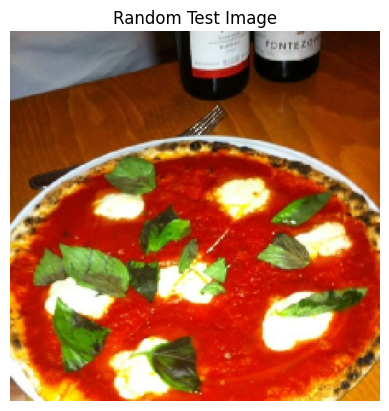

In [88]:
img = load_img(random_image_path, target_size=(224, 224))
img_arr = img_to_array(img)

plt.imshow(img_arr.astype("uint8"))
plt.axis("off")
plt.title("Random Test Image")
final_pred = meta_model.predict(meta_X_single)[0][0]
if final_pred > 0.5:
    print("FINAL PREDICTION: STEAK ")
else:
    print("FINAL PREDICTION: PIZZA ")

print("Meta-model raw probability:", final_pred)